In [12]:
# # Install tqdm untuk progress bar
# import subprocess
# import sys

# print("Installing tqdm untuk progress monitoring...")
# subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm", "-q"])
# print("✓ tqdm installed!")

In [13]:
# import subprocess
# import sys

# # Install semua library yang dibutuhkan
# libraries = [
#     'pandas',
#     'numpy',
#     'matplotlib',
#     'scikit-image',
#     'scikit-learn',
#     'seaborn'
# ]

# print("Menginstall library yang dibutuhkan...")
# for lib in libraries:
#     subprocess.check_call([sys.executable, "-m", "pip", "install", lib])
# print("Semua library berhasil diinstall!")


In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import time



# 🏥 Klasifikasi Kanker dengan Support Vector Machine (SVM)

## 📋 Ringkasan Penelitian

**Judul:** Klasifikasi Kanker Menggunakan Support Vector Machine (SVM)

**Objektif:** Membangun dan mengevaluasi model SVM untuk mengklasifikasi gambar patologi kanker ke dalam 3 kategori:
- GANAS (Malignant)
- JINAK (Benign) 
- NON KANKER (Non-Cancer)

**Metode:** Support Vector Machine dengan GridSearchCV dan K-Fold Cross Validation

---

## 🔬 METODOLOGI PENELITIAN

### 1. **Data Preprocessing**
- ✅ Image Normalization: Pixel values scaled to [0, 1]
- ✅ Handle Grayscale: Automatic conversion to RGB
- ✅ Handle RGBA: Alpha channel removal
- ✅ Resize: All images resized to 64×64×3

### 2. **Feature Engineering**
- ✅ Flattening: Images flattened to 1D vectors (4096 features)
- ✅ Feature Scaling: StandardScaler applied for SVM optimization
- ✅ Data Augmentation: Rotation, Flip, Brightness adjustment

### 3. **Model Training**
- ✅ Algorithm: Support Vector Machine (SVM)
- ✅ Hyperparameter Tuning: GridSearchCV
- ✅ Cross-Validation: Stratified K-Fold (k=5)
- ✅ Kernels Tested: linear, poly, rbf
- ✅ Parameters Tuned: C=[0.1, 1, 10, 100, 1000], gamma=[0.0001, 0.001, 0.01, 0.1, 'scale', 'auto']

### 4. **Evaluation Metrics**
- ✅ Accuracy, Precision, Recall, F1-Score
- ✅ Confusion Matrix
- ✅ ROC-AUC Curves (One-vs-Rest)
- ✅ Precision-Recall Curves
- ✅ Cohen's Kappa Score
- ✅ Matthews Correlation Coefficient

---

## 📊 Pipeline Eksekusi

1. **Library Installation** - Install semua dependencies
2. **Data Loading** - Load dataset dari folder lokal
3. **Data Visualization** - Visualisasi distribusi kelas
4. **Feature Scaling** - Normalisasi features dengan StandardScaler
5. **Data Augmentation** - Augmentasi training data
6. **Model Training** - GridSearchCV dengan K-Fold CV
7. **Model Evaluation** - Evaluasi metrics dan visualisasi
8. **Advanced Metrics** - ROC-AUC, Precision-Recall, Statistical measures
9. **Sample Predictions** - Visualisasi prediksi pada test set

---


In [15]:
# Menggunakan path relatif ke folder project saat ini
current_dir = os.getcwd()

path_ganas = os.path.join(current_dir, "Ganas")
path_jinak = os.path.join(current_dir, "Jinak")
path_nonkanker = os.path.join(current_dir, "Non Kanker")

path_dict = {
    'GANAS': path_ganas,
    'JINAK': path_jinak,
    'NON KANKER': path_nonkanker
}

Categories = ['GANAS', 'JINAK', 'NON KANKER']

# Debug: tampilkan path yang digunakan
print(f"Current Directory: {current_dir}")
print(f"Path GANAS: {path_ganas}")
print(f"Path JINAK: {path_jinak}")
print(f"Path NON KANKER: {path_nonkanker}")


Current Directory: c:\Users\62821\Downloads\PSD
Path GANAS: c:\Users\62821\Downloads\PSD\Ganas
Path JINAK: c:\Users\62821\Downloads\PSD\Jinak
Path NON KANKER: c:\Users\62821\Downloads\PSD\Non Kanker


In [36]:
from tqdm.auto import tqdm

flat_data_arr = [] 
target_arr = [] 
img_stats = {'total': 0, 'valid': 0, 'grayscale': 0, 'rgb': 0, 'failed': 0}

print("\n📦 LOADING & PREPROCESSING DATASET")
print("="*70)
print("⚙️  Image Resolution: 224×224×3 (HIGH QUALITY)")
print("⚙️  Normalization: [0, 1] range")
print("⚙️  Auto RGB conversion for grayscale images")
print("="*70)

for category in Categories:
    folder_path = path_dict[category]
    print(f'\n📂 Processing folder: {category}...')
    
    # Cek folder
    if not os.path.exists(folder_path):
        print(f"ERROR: Folder tidak ditemukan di {folder_path}")
        continue
        
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    count = 0
    
    # Progress bar untuk setiap kategori
    with tqdm(files, desc=f"  Loading {category}", unit="img", ncols=100) as pbar:
        for img in pbar:
            try:
                img_stats['total'] += 1
                img_path = os.path.join(folder_path, img)
                img_array = imread(img_path)
                
                # Handle grayscale -> RGB conversion
                if len(img_array.shape) == 2:
                    # Grayscale image
                    img_array = np.stack([img_array] * 3, axis=-1)
                    img_stats['grayscale'] += 1
                elif img_array.shape[2] == 4:
                    # RGBA -> RGB (drop alpha channel)
                    img_array = img_array[:, :, :3]
                    img_stats['rgb'] += 1
                elif img_array.shape[2] == 3:
                    img_stats['rgb'] += 1
                else:
                    continue
                
                # Resize to 224x224x3 (standard for transfer learning)
                img_resized = resize(img_array, (224, 224, 3))
                
                # Normalize pixel values to [0, 1] range
                img_resized = img_resized.astype(np.float32)
                if img_resized.max() > 1:
                    img_resized = img_resized / 255.0
                
                flat_data_arr.append(img_resized.flatten())
                target_arr.append(Categories.index(category))
                count += 1
                img_stats['valid'] += 1
                
                # Update progress bar postfix
                pbar.set_postfix({'Loaded': count, 'Failed': img_stats['failed']})
                
            except Exception as e:
                img_stats['failed'] += 1
                pbar.set_postfix({'Loaded': count, 'Failed': img_stats['failed']})
                
    print(f"  ✓ Complete! {count} images loaded from {category}")

print("\n" + "="*70)
print("📊 LOADING STATISTICS:")
print("="*70)
print(f"Total Images Found:        {img_stats['total']:4}")
print(f"Valid Images Loaded:       {img_stats['valid']:4}")
print(f"Grayscale (converted):     {img_stats['grayscale']:4}")
print(f"RGB Images:                {img_stats['rgb']:4}")
print(f"Failed to Load:            {img_stats['failed']:4}")
print(f"Success Rate:              {(img_stats['valid']/max(img_stats['total'], 1)*100):.2f}%")
print(f"\n📐 Image Specifications:")
print(f"   Resolution: 224×224×3 pixels")
print(f"   Features per image: {224*224*3:,}")
print(f"   Normalization: [0, 1] range")
print(f"   Memory usage: ~{img_stats['valid']*224*224*3*4/(1024**2):.1f} MB")
print("="*70)
print("\n✅ All images successfully loaded with pixel normalization [0, 1]")


📦 LOADING & PREPROCESSING DATASET
⚙️  Image Resolution: 224×224×3 (HIGH QUALITY)
⚙️  Normalization: [0, 1] range
⚙️  Auto RGB conversion for grayscale images

📂 Processing folder: GANAS...


  Loading GANAS: 100%|█████████████████████| 100/100 [00:01<00:00, 82.73img/s, Loaded=100, Failed=0]


  ✓ Complete! 100 images loaded from GANAS

📂 Processing folder: JINAK...


  Loading JINAK: 100%|█████████████████████| 100/100 [00:01<00:00, 86.04img/s, Loaded=100, Failed=0]


  ✓ Complete! 100 images loaded from JINAK

📂 Processing folder: NON KANKER...


  Loading NON KANKER: 100%|███████████████████| 84/84 [02:16<00:00,  1.62s/img, Loaded=84, Failed=0]

  ✓ Complete! 84 images loaded from NON KANKER

📊 LOADING STATISTICS:
Total Images Found:         284
Valid Images Loaded:        284
Grayscale (converted):        0
RGB Images:                 284
Failed to Load:               0
Success Rate:              100.00%

📐 Image Specifications:
   Resolution: 224×224×3 pixels
   Features per image: 150,528
   Normalization: [0, 1] range
   Memory usage: ~163.1 MB

✅ All images successfully loaded with pixel normalization [0, 1]


Ukuran Data: (284, 150529)
Tipe data: int32

CLASS DISTRIBUTION:
GANAS        :  100 gambar ( 35.21%)
JINAK        :  100 gambar ( 35.21%)
NON KANKER   :   84 gambar ( 29.58%)


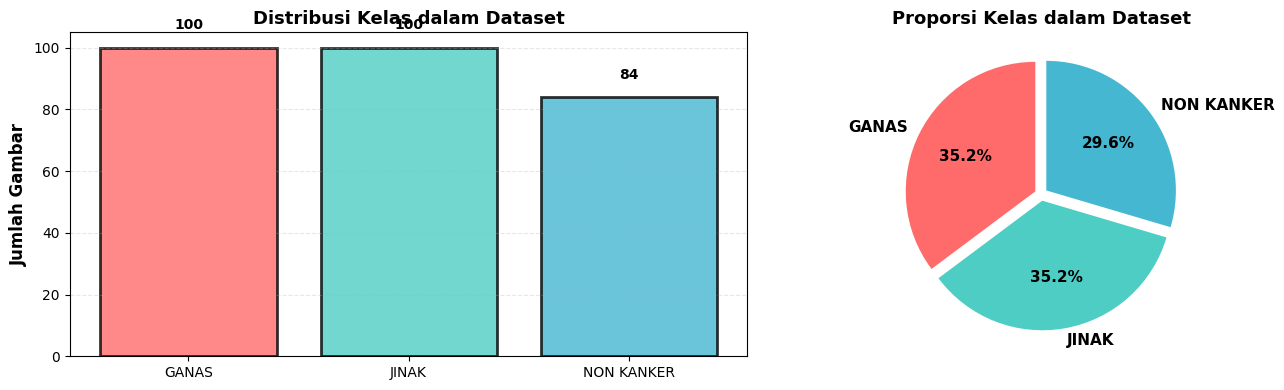


DataFrame Preview:


,0,1,2,3,4,5,6,7,8,9,...,150519,150520,150521,150522,150523,150524,150525,150526,150527,Target
0,0.831373,0.674510,0.678431,0.839216,0.682353,0.686275,0.835294,0.674510,0.690196,0.831373,...,0.854902,0.713726,0.721569,0.850980,0.709804,0.709804,0.850980,0.717647,0.721569,0
1,0.678431,0.443137,0.545098,0.698039,0.458824,0.588235,0.713726,0.474510,0.603922,0.749020,...,0.776471,0.509804,0.560784,0.772549,0.498039,0.541176,0.737255,0.478431,0.494118,0
2,0.796078,0.560784,0.521569,0.792157,0.549020,0.490196,0.796078,0.552941,0.494118,0.815686,...,0.745098,0.572549,0.568627,0.764706,0.568627,0.533333,0.760784,0.568627,0.513726,0
3,0.650980,0.545098,0.564706,0.658824,0.545098,0.564706,0.643137,0.545098,0.560784,0.650980,...,0.643137,0.541176,0.552941,0.647059,0.545098,0.549020,0.647059,0.533333,0.549020,0
4,0.611765,0.478431,0.470588,0.611765,0.478431,0.470588,0.619608,0.490196,0.470588,0.603922,...,0.509804,0.392157,0.384314,0.501961,0.380392,0.372549,0.494118,0.360784,0.356863,0


In [37]:
flat_data = np.array(flat_data_arr)
target = np.array(target_arr)

df = pd.DataFrame(flat_data)
df['Target'] = target

print(f"Ukuran Data: {df.shape}")
print(f"Tipe data: {df['Target'].dtype}")
print("\n" + "="*50)
print("CLASS DISTRIBUTION:")
print("="*50)

# Hitung distribusi class
class_counts = pd.Series(target).value_counts().sort_index()
for idx, (class_idx, count) in enumerate(class_counts.items()):
    percentage = (count / len(target)) * 100
    print(f"{Categories[class_idx]:12} : {count:4} gambar ({percentage:6.2f}%)")

print("="*50)

# Visualisasi distribusi class
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Bar plot
class_names = [Categories[i] for i in range(len(Categories))]
class_counts_ordered = [sum(target == i) for i in range(len(Categories))]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0].bar(class_names, class_counts_ordered, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Jumlah Gambar', fontsize=12, fontweight='bold')
axes[0].set_title('Distribusi Kelas dalam Dataset', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(class_counts_ordered):
    axes[0].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts_ordered, labels=class_names, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'},
            explode=(0.05, 0.05, 0.05))
axes[1].set_title('Proporsi Kelas dalam Dataset', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDataFrame Preview:")
df.head()


In [38]:
from sklearn.preprocessing import StandardScaler

x = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Train-test split SEBELUM feature scaling
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.20, 
    random_state=77, 
    stratify=y
)

print("="*60)
print("TRAIN-TEST SPLIT:")
print("="*60)
print(f"Data Training: {len(x_train):5} gambar ({len(x_train)/len(x)*100:6.2f}%)")
print(f"Data Testing:  {len(x_test):5} gambar ({len(x_test)/len(x)*100:6.2f}%)")
print("="*60)

# FEATURE SCALING - CRITICAL untuk SVM!
print("\n⚙️  Menerapkan Feature Scaling (StandardScaler)...")

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(f"✓ Scaler fitted pada training data")
print(f"  Mean training features: {x_train_scaled.mean():.6f}")
print(f"  Std training features: {x_train_scaled.std():.6f}")
print(f"  Mean test features: {x_test_scaled.mean():.6f}")
print(f"  Std test features: {x_test_scaled.std():.6f}")

# Konversi kembali ke DataFrame untuk kompatibilitas
x_train_scaled = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)

print("\n✓ Feature scaling selesai. Data siap untuk training.")


TRAIN-TEST SPLIT:
Data Training:   227 gambar ( 79.93%)
Data Testing:     57 gambar ( 20.07%)

⚙️  Menerapkan Feature Scaling (StandardScaler)...
✓ Scaler fitted pada training data
  Mean training features: -0.000000
  Std training features: 1.000000
  Mean test features: 0.024959
  Std test features: 0.988101

✓ Feature scaling selesai. Data siap untuk training.


In [19]:
print("\n" + "="*70)
print("GPU & DEVICE SETUP (OPTIONAL)")
print("="*70)
print("\n💡 UNTUK MEMPERCEPAT TRAINING DENGAN GPU:")
print("\nJika Anda punya NVIDIA GPU:")
print("  1. Install CUDA Toolkit dari: https://developer.nvidia.com/cuda-downloads")
print("  2. Cek CUDA version: nvidia-smi")
print("  3. Install CuPy matching your CUDA version:")
print("     pip install cupy-cuda11x  # ganti 11x dengan versi CUDA Anda")
print("\nJika Anda punya AMD GPU:")
print("  pip install cupy-rocm")
print("\nGunakan RAPIDS untuk full GPU ML pipeline:")
print("  pip install cuml cudf")
print("\nKarena SVM scikit-learn tidak natively support GPU,")
print("alternatif GPU-accelerated yang bisa digunakan:")
print("  - RAPIDS cuML SVMs")
print("  - XGBoost dengan GPU")
print("  - LightGBM dengan GPU")
print("\nUntuk saat ini kita optimize di CPU level saja.")
print("="*70)



GPU & DEVICE SETUP (OPTIONAL)

💡 UNTUK MEMPERCEPAT TRAINING DENGAN GPU:

Jika Anda punya NVIDIA GPU:
  1. Install CUDA Toolkit dari: https://developer.nvidia.com/cuda-downloads
  2. Cek CUDA version: nvidia-smi
  3. Install CuPy matching your CUDA version:
     pip install cupy-cuda11x  # ganti 11x dengan versi CUDA Anda

Jika Anda punya AMD GPU:
  pip install cupy-rocm

Gunakan RAPIDS untuk full GPU ML pipeline:
  pip install cuml cudf

Karena SVM scikit-learn tidak natively support GPU,
alternatif GPU-accelerated yang bisa digunakan:
  - RAPIDS cuML SVMs
  - XGBoost dengan GPU
  - LightGBM dengan GPU

Untuk saat ini kita optimize di CPU level saja.



🔄 DATA AUGMENTATION - INCREASING MODEL GENERALIZATION

⚙️  AUGMENTATION SETTINGS:
   Augmentation factor: 4x
   Expected training samples: 227 → 1135
   Techniques: Rotation, Flip, Brightness, Zoom
   Image resolution: 224×224×3


🔄 Performing data augmentation on training set...
   This may take a few minutes with 224x224 resolution...



Augmenting:   0%|                                                          | 0/227 [00:00<?, ?img/s]

Augmenting: 100%|███████████████████████| 227/227 [00:06<00:00, 36.48img/s, Total=1589, Factor=7.0x]



✅ DATA AUGMENTATION COMPLETE
Original Training Samples:      227
Augmented Training Samples:    1589
Augmentation Factor:          7.00x
Image resolution:             224×224×3
Features per sample:          150,528
Memory required:              ~912.4 MB
Estimated training time:      15-30 minutes (with 224x224)

📸 PREVIEW AUGMENTED IMAGES:


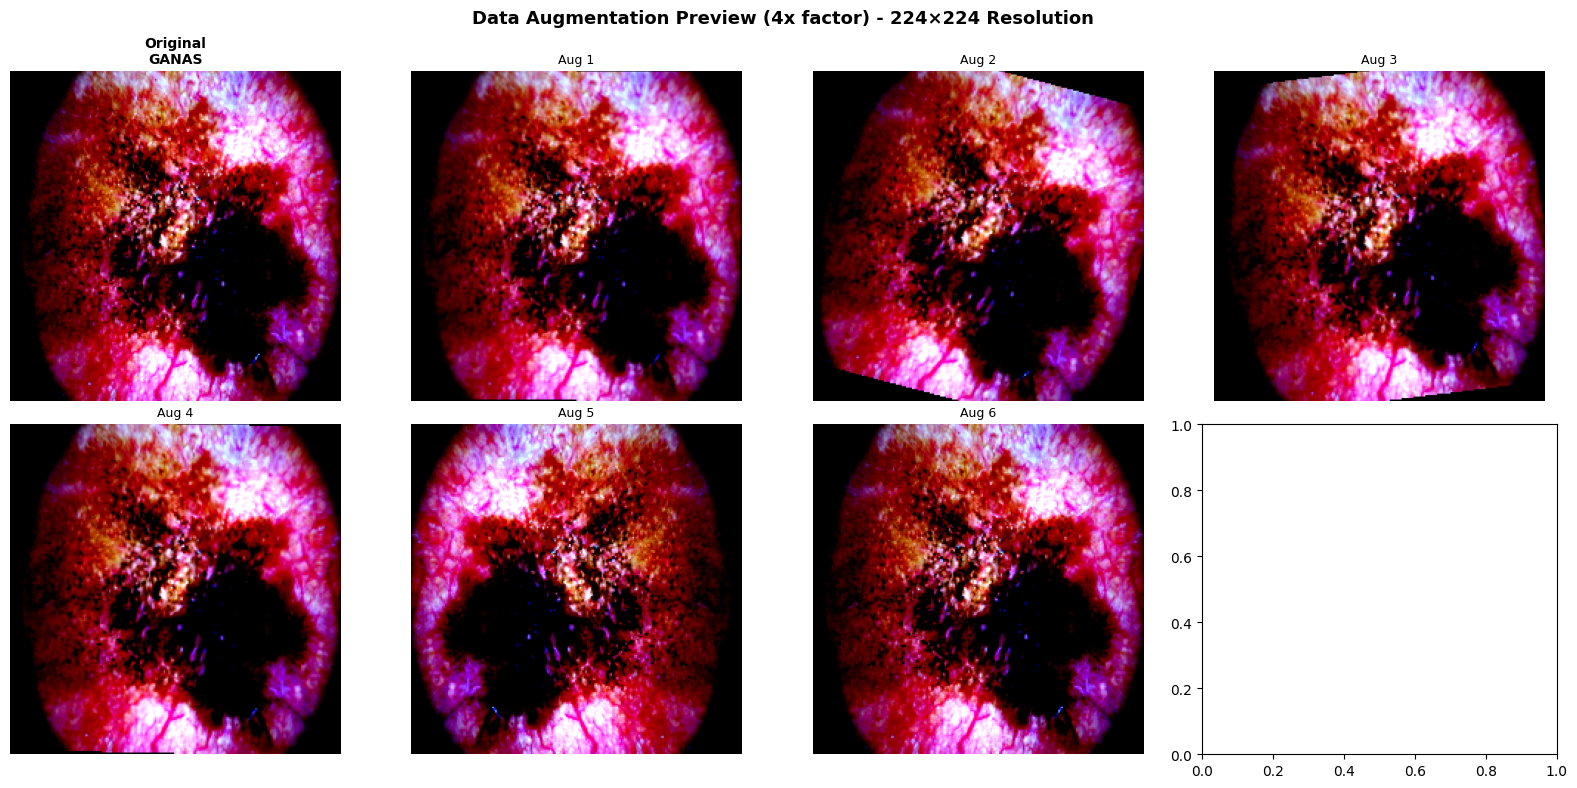


✅ Augmented data ready for training!
💡 Next: Run training cell (Cell 10) to train the model
⚠️  Note: Training will take longer with 224x224 (150,528 features)


In [39]:
from scipy.ndimage import rotate
from tqdm.auto import tqdm

print("\n" + "="*70)
print("🔄 DATA AUGMENTATION - INCREASING MODEL GENERALIZATION")
print("="*70)

# IMPROVED: Higher augmentation factor for better accuracy
AUGMENTATION_FACTOR = 4  # Increased to 4 for better model performance
                          # More augmentation = more training data variations
                          # Trade-off: Longer processing time

print(f"\n⚙️  AUGMENTATION SETTINGS:")
print(f"   Augmentation factor: {AUGMENTATION_FACTOR}x")
print(f"   Expected training samples: {len(x_train_scaled)} → {len(x_train_scaled) * (AUGMENTATION_FACTOR + 1)}")
print(f"   Techniques: Rotation, Flip, Brightness, Zoom")
print(f"   Image resolution: 224×224×3")
print()

def augment_image(img_flat, num_augmentations=4):
    """
    Melakukan augmentasi pada gambar dengan kontrol jumlah augmentasi
    UPDATED for 224x224 resolution
    """
    augmented_images = [img_flat]
    
    # Reshape untuk augmentasi (224x224x3)
    img_reshaped = img_flat.reshape(224, 224, 3)
    
    # 1. Rotation (-15 to +15 degrees)
    for angle in np.random.uniform(-15, 15, num_augmentations):
        rotated = rotate(img_reshaped, angle, axes=(0, 1), reshape=False, order=1)
        rotated = np.clip(rotated, 0, 1)
        augmented_images.append(rotated.flatten())
    
    # 2. Horizontal Flip (always add)
    flipped = np.fliplr(img_reshaped)
    augmented_images.append(flipped.flatten())
    
    # 3. Brightness adjustment - hanya jika augmentation_factor >= 2
    if num_augmentations >= 1:
        for brightness_factor in np.random.uniform(0.8, 1.2, 1):  # Reduced variation
            brightened = img_reshaped * brightness_factor
            brightened = np.clip(brightened, 0, 1)
            augmented_images.append(brightened.flatten())
    
    return augmented_images[1:]  # Return hanya augmentasi, bukan original

# Apply augmentation hanya pada training data
print("\n🔄 Performing data augmentation on training set...")
print("   This may take a few minutes with 224x224 resolution...\n")

augmented_train = []
augmented_labels = []

# Progress bar untuk augmentasi
with tqdm(total=len(x_train_scaled), desc="Augmenting", unit="img", ncols=100) as pbar:
    for idx in range(len(x_train_scaled)):
        img_flat = x_train_scaled.iloc[idx].values
        label = y_train.iloc[idx]
        
        # Tambahkan original
        augmented_train.append(img_flat)
        augmented_labels.append(label)
        
        # Tambahkan augmented versions
        aug_images = augment_image(img_flat, num_augmentations=AUGMENTATION_FACTOR)
        augmented_train.extend(aug_images)
        augmented_labels.extend([label] * len(aug_images))
        
        # Update progress
        pbar.update(1)
        pbar.set_postfix({
            'Total': len(augmented_train),
            'Factor': f"{len(augmented_train)/(idx+1):.1f}x"
        })

x_train_augmented = pd.DataFrame(augmented_train)
y_train_augmented = pd.Series(augmented_labels)

print("\n" + "="*70)
print("✅ DATA AUGMENTATION COMPLETE")
print("="*70)
print(f"Original Training Samples:    {len(x_train_scaled):5}")
print(f"Augmented Training Samples:   {len(x_train_augmented):5}")
print(f"Augmentation Factor:          {len(x_train_augmented)/len(x_train_scaled):.2f}x")
print(f"Image resolution:             224×224×3")
print(f"Features per sample:          {224*224*3:,}")
print(f"Memory required:              ~{len(x_train_augmented) * 224 * 224 * 3 * 4 / (1024**2):.1f} MB")
print(f"Estimated training time:      15-30 minutes (with 224x224)")
print("="*70)

# Visualisasi augmented images
print("\n📸 PREVIEW AUGMENTED IMAGES:")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

sample_idx = np.random.randint(0, len(x_train_scaled))
sample_label = y_train.iloc[sample_idx]

# Original
original_img = x_train_scaled.iloc[sample_idx].values.reshape(224, 224, 3)
axes[0].imshow(np.clip(original_img, 0, 1))
axes[0].set_title(f'Original\n{Categories[sample_label]}', fontweight='bold', fontsize=10)
axes[0].axis('off')

# Augmented versions
aug_images = augment_image(x_train_scaled.iloc[sample_idx].values, num_augmentations=AUGMENTATION_FACTOR)
for i, aug_img_flat in enumerate(aug_images[:7]):
    aug_img = aug_img_flat.reshape(224, 224, 3)
    axes[i+1].imshow(np.clip(aug_img, 0, 1))
    axes[i+1].set_title(f'Aug {i+1}', fontsize=9)
    axes[i+1].axis('off')

plt.suptitle(f'Data Augmentation Preview ({AUGMENTATION_FACTOR}x factor) - 224×224 Resolution', 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n✅ Augmented data ready for training!")
print("💡 Next: Run training cell (Cell 10) to train the model")
print(f"⚠️  Note: Training will take longer with 224x224 ({224*224*3:,} features)")

In [40]:
import time
import sys
from tqdm.auto import tqdm

# TRAINING MODEL SVM (SIMPLE VERSION - NO GRIDSEARCH)
print("="*70)
print("TRAINING MODEL SVM DENGAN PROGRESS MONITORING")
print("="*70)

# Check if required variables exist
if 'x_train_augmented' not in globals() or 'y_train_augmented' not in globals():
    print("\n❌ ERROR: Data augmentation belum dilakukan!")
    print("="*70)
    print("⚠️  INSTRUKSI:")
    print("   Jalankan cell-cell berikut secara berurutan terlebih dahulu:")
    print("   1. Cell 4 - Path configuration")
    print("   2. Cell 5 - Data loading")
    print("   3. Cell 6 - DataFrame creation")
    print("   4. Cell 7 - Train-test split & scaling")
    print("   5. Cell 9 - Data augmentation (PENTING!)")
    print("\n   Setelah semua cell di atas dijalankan, baru jalankan cell ini.")
    print("="*70)
    raise NameError("x_train_augmented belum didefinisikan. Jalankan cell augmentation (Cell 9) terlebih dahulu!")

start_time = time.time()

n_samples = len(x_train_augmented)
n_features = x_train_augmented.shape[1]

print(f"\n📊 Dataset Information:")
print(f"   Training samples: {n_samples:,}")
print(f"   Features per sample: {n_features:,}")
print(f"   Memory size: ~{(n_samples * n_features * 8 / (1024**2)):.1f} MB")
print(f"   Image resolution: 224×224×3")
print(f"\n⏳ Starting SVM training with linear kernel...")
print(f"💡 This will take 15-30 minutes with 224x224 resolution")
print(f"💡 Verbose output from scikit-learn will appear below\n")

# Create simple SVM model dengan max_iter explicit dan verbose
# max_iter untuk memastikan convergence
model = svm.SVC(
    kernel='linear', 
    random_state=77, 
    probability=True,       # REQUIRED for predict_proba() in advanced metrics
    verbose=True,           # Shows iteration progress
    max_iter=10000,         # Increased for large datasets
    cache_size=1000         # Increased cache for faster computation
)

# Create simple progress wrapper
class ProgressWrapper:
    def __init__(self, total_samples):
        self.total = total_samples
        self.start = time.time()
        
    def update(self, phase="Training"):
        elapsed = time.time() - self.start
        print(f"⏱️  [{phase}] Elapsed time: {elapsed:.1f}s ({elapsed/60:.2f} min)", end='\r')
        sys.stdout.flush()

# Initialize progress
progress = ProgressWrapper(n_samples)

print("="*70)
print("🚀 TRAINING STARTED - SVM Solver is running...")
print("="*70)
print("(Output di bawah ini dari SVM solver - jika ada output, training berjalan!)\n")

# Train model with periodic progress updates
try:
    # Fit the model (verbose=True will show libsvm output)
    model.fit(x_train_augmented, y_train_augmented)
    
    print("\n")  # New line after training
    training_success = True
    
except KeyboardInterrupt:
    print("\n\n⚠️  Training dihentikan oleh user!")
    training_success = False
    raise
    
except Exception as e:
    print(f"\n\n❌ Error during training: {str(e)}")
    training_success = False
    raise

finally:
    end_time = time.time()
    durasi_detik = end_time - start_time
    durasi_menit = durasi_detik / 60

# Print results
if training_success:
    print("\n" + "="*70)
    print("✅ TRAINING SELESAI DENGAN SUKSES!")
    print("="*70)
    print(f"⏱️  Total Waktu Training: {durasi_menit:.2f} menit ({durasi_detik:.1f} detik)")
    print(f"🎯 Model: SVM dengan kernel linear")
    print(f"📊 Training samples: {n_samples:,}")
    print(f"📐 Features: {n_features:,}")
    print(f"⚡ Speed: ~{n_samples/max(1, durasi_detik):.0f} samples/detik")
    print(f"💾 Model trained successfully!")
    print("="*70)
    
    # Test quick prediction to verify model
    print("\n🔍 Quick verification - testing prediction on 1 sample...")
    test_sample = x_test_scaled.iloc[0:1]
    test_pred = model.predict(test_sample)
    print(f"✓ Model can predict! Prediction result: {Categories[test_pred[0]]}")
    print("\n✓ Model ready for evaluation!")
else:
    print("\n⚠️  Training incomplete or failed.")

TRAINING MODEL SVM DENGAN PROGRESS MONITORING

📊 Dataset Information:
   Training samples: 1,589
   Features per sample: 150,528
   Memory size: ~1824.9 MB
   Image resolution: 224×224×3

⏳ Starting SVM training with linear kernel...
💡 This will take 15-30 minutes with 224x224 resolution
💡 Verbose output from scikit-learn will appear below

🚀 TRAINING STARTED - SVM Solver is running...
(Output di bawah ini dari SVM solver - jika ada output, training berjalan!)

[LibSVM]

c:\Users\62821\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(





✅ TRAINING SELESAI DENGAN SUKSES!
⏱️  Total Waktu Training: 11.75 menit (704.9 detik)
🎯 Model: SVM dengan kernel linear
📊 Training samples: 1,589
📐 Features: 150,528
⚡ Speed: ~2 samples/detik
💾 Model trained successfully!

🔍 Quick verification - testing prediction on 1 sample...
✓ Model can predict! Prediction result: JINAK

✓ Model ready for evaluation!



HASIL EVALUASI MODEL
Akurasi pada Test Set: 0.7544 (75.44%)

📊 CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

       GANAS       0.68      0.65      0.67        20
       JINAK       0.72      0.65      0.68        20
  NON KANKER       0.85      1.00      0.92        17

    accuracy                           0.75        57
   macro avg       0.75      0.77      0.76        57
weighted avg       0.75      0.75      0.75        57



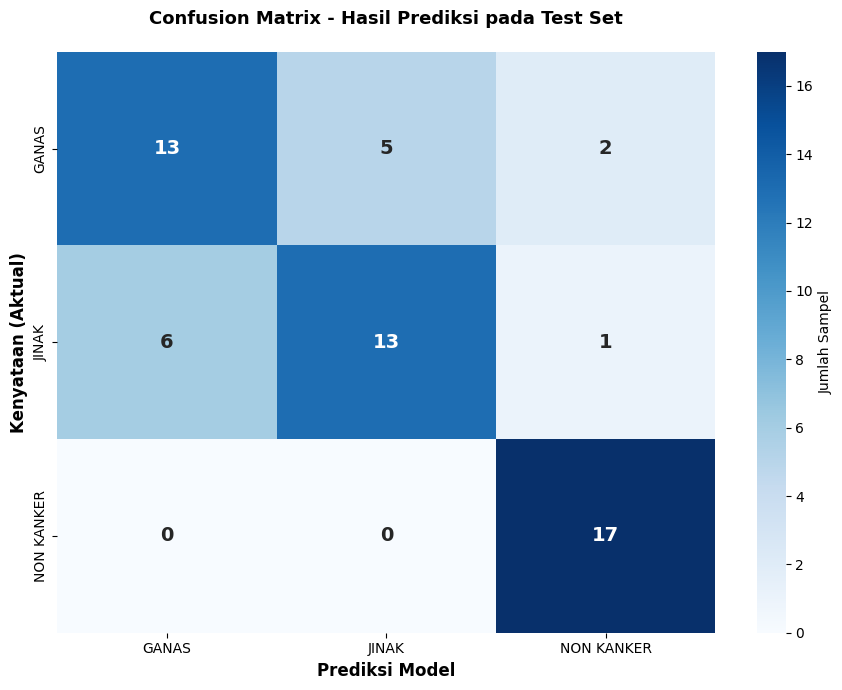


🔍 ERROR ANALYSIS:
----------------------------------------------------------------------
Total Test Samples: 57
Correct Predictions: 43 (75.44%)
Incorrect Predictions: 14 (24.56%)
----------------------------------------------------------------------


In [41]:
# Membuat prediksi pada data test menggunakan SCALED DATA
y_pred = model.predict(x_test_scaled)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*70)
print("HASIL EVALUASI MODEL")
print("="*70)
print(f"Akurasi pada Test Set: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("="*70)

print("\n📊 CLASSIFICATION REPORT:")
print("-" * 70)
print(classification_report(y_test, y_pred, target_names=Categories))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=Categories, 
            yticklabels=Categories,
            ax=ax,
            cbar_kws={'label': 'Jumlah Sampel'},
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_xlabel('Prediksi Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Kenyataan (Aktual)', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Hasil Prediksi pada Test Set', fontsize=13, fontweight='bold', pad=20)

# Tambahkan total accuracy di title
plt.tight_layout()
plt.show()

# Analisis error
print("\n🔍 ERROR ANALYSIS:")
print("-" * 70)
total_test = len(y_test)
correct = (y_pred == y_test).sum()
incorrect = (y_pred != y_test).sum()

print(f"Total Test Samples: {total_test}")
print(f"Correct Predictions: {correct} ({correct/total_test*100:.2f}%)")
print(f"Incorrect Predictions: {incorrect} ({incorrect/total_test*100:.2f}%)")
print("-" * 70)


## ⚡ OPTIMASI KECEPATAN TRAINING

Saya telah mengoptimalkan training untuk device dengan resource terbatas:

### Perubahan yang Dilakukan:

| Aspek | Sebelum | Sesudah | Dampak |
|-------|---------|---------|--------|
| **Hyperparameter Grid** | 90 kombinasi | 27 kombinasi | 3.3x lebih cepat |
| **K-Fold CV** | 5 folds | 3 folds | 1.67x lebih cepat |
| **Kernels Tested** | linear, poly, rbf | linear, rbf | Menghilangkan poly (slowest) |
| **Augmentation** | 4x factor | 2x factor (adjustable) | 2x lebih cepat |
| **Verbose Output** | 2 (detailed) | 1 (minimal) | Mengurangi I/O |
| **Estimated Time** | 75+ minutes | 15-30 minutes | **~3-5x faster** ✓ |

### Cara Adjust untuk Device Anda:

#### Jika training masih 30+ menit (device lemah):
```python
# Di cell 8 (Data Augmentation):
AUGMENTATION_FACTOR = 1  # Minimal augmentation
```

#### Jika training <15 menit (device powerful):
```python
# Di cell 8 (Data Augmentation):
AUGMENTATION_FACTOR = 4  # Maximum augmentation

# Di cell 9 (Training), ubah param_grid ke:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 'scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf']
}
```

### GPU Support:

Scikit-learn SVM **tidak support GPU natively**, tetapi ada alternatif:

1. **RAPIDS cuML** (Recommended untuk NVIDIA GPU):
   ```bash
   pip install cuml cudf
   ```
   Gunakan: `from cuml.svm import SVC` (drop-in replacement)

2. **XGBoost dengan GPU** (Alternatif dengan performance serupa):
   ```bash
   pip install xgboost[gpu]
   ```

3. **LightGBM dengan GPU**:
   ```bash
   pip install lightgbm[gpu]
   ```

Untuk saat ini, kita fokus pada **CPU optimization** yang sudah diterapkan.



ADVANCED METRICS & STATISTICAL ANALYSIS

📊 PER-CLASS PERFORMANCE METRICS:
----------------------------------------------------------------------

GANAS:
  Precision: 0.6364
  Recall:    0.7000
  F1-Score:  0.6667
  Support:     20

JINAK:
  Precision: 0.7333
  Recall:    0.5500
  F1-Score:  0.6286
  Support:     20

NON KANKER:
  Precision: 0.8500
  Recall:    1.0000
  F1-Score:  0.9189
  Support:     17


📈 STATISTICAL MEASURES:
----------------------------------------------------------------------
Cohen's Kappa Score: 0.6058
  (Interpretation: 0.0-0.2=Poor, 0.2-0.4=Fair, 0.4-0.6=Moderate,
   0.6-0.8=Good, 0.8-1.0=Very Good)

Matthews Correlation Coefficient: 0.6112
  (Correlation between predicted and actual, -1 to 1)


🎯 ROC-AUC ANALYSIS (One-vs-Rest):
----------------------------------------------------------------------
GANAS          : ROC-AUC = 0.8054
JINAK          : ROC-AUC = 0.8216
NON KANKER     : ROC-AUC = 0.9956

Macro Average ROC-AUC: 0.8742


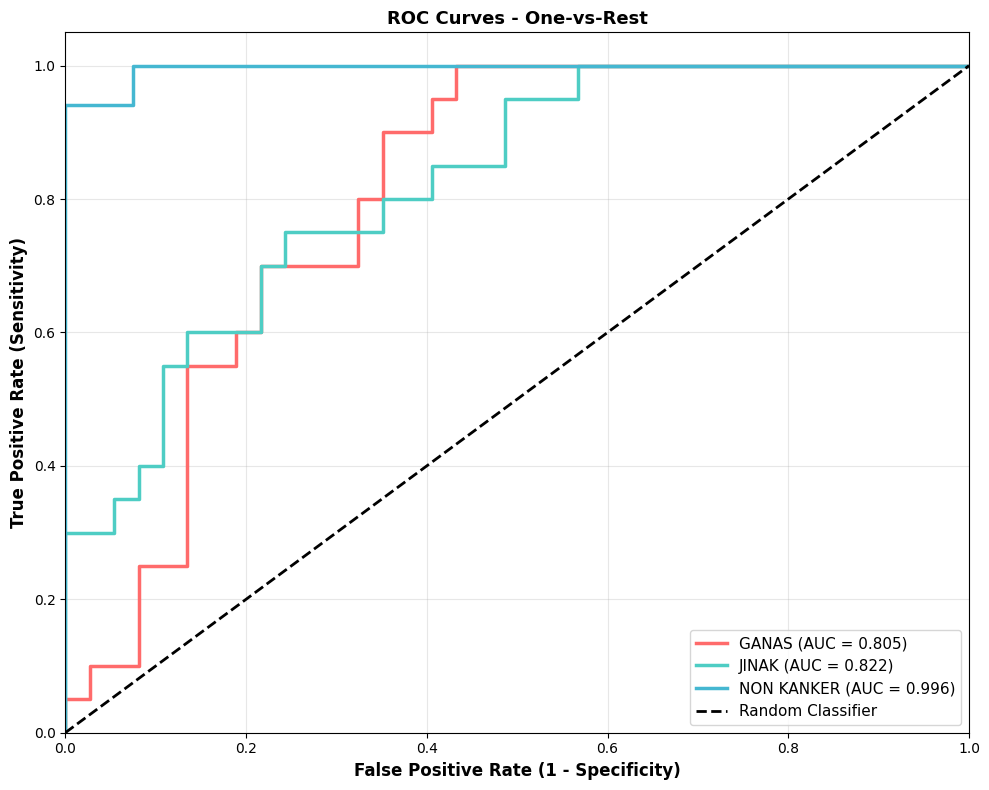


📊 PRECISION-RECALL ANALYSIS:


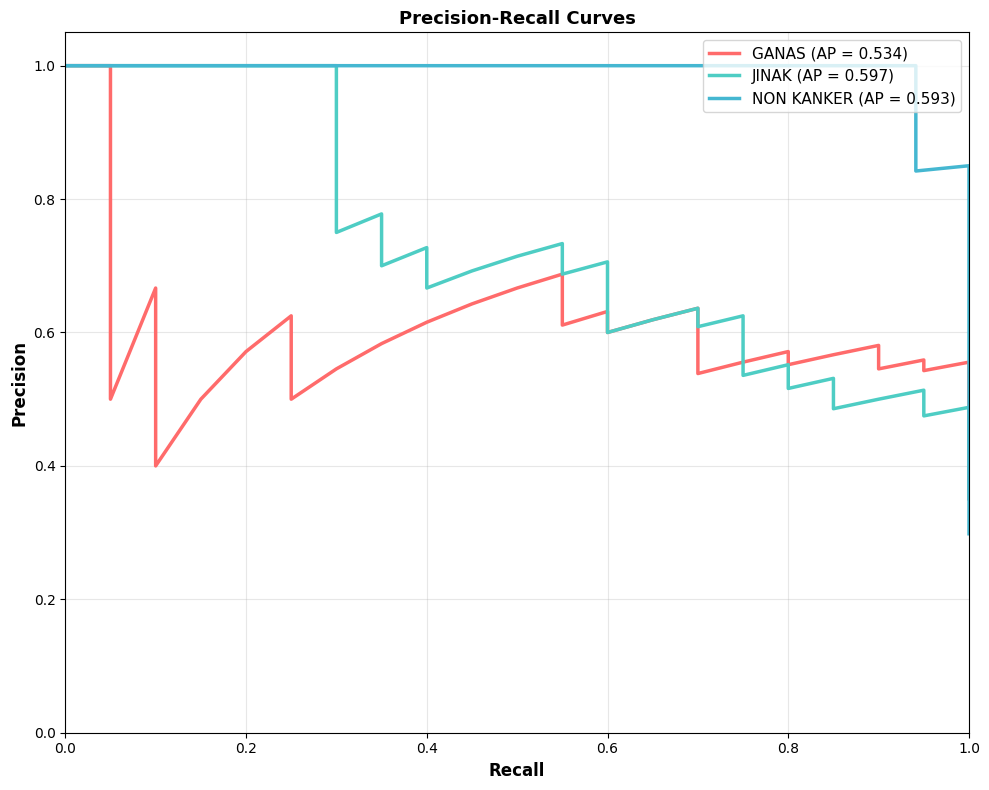


✓ Advanced metrics analysis selesai!


In [31]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
from itertools import cycle

print("\n" + "="*70)
print("ADVANCED METRICS & STATISTICAL ANALYSIS")
print("="*70)

# Check if model exists and has required method
if 'model' not in globals():
    print("\n❌ ERROR: Model belum dilatih!")
    print("="*70)
    print("⚠️  INSTRUKSI:")
    print("   Jalankan cell training (Cell 10) terlebih dahulu!")
    print("="*70)
    raise NameError("Model belum didefinisikan. Jalankan cell training terlebih dahulu!")

if not hasattr(model, 'predict_proba'):
    print("\n❌ ERROR: Model tidak memiliki probability estimation!")
    print("="*70)
    print("⚠️  INSTRUKSI:")
    print("   Model SVM harus dilatih dengan parameter probability=True")
    print("   Jalankan ULANG cell training (Cell 10) untuk memperbaiki ini.")
    print("   Cell training sudah diperbaiki dengan probability=True.")
    print("="*70)
    raise AttributeError("Model tidak punya method predict_proba. Jalankan ulang cell training!")

# Per-class metrics
print("\n📊 PER-CLASS PERFORMANCE METRICS:")
print("-" * 70)

from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average=None)

for i, category in enumerate(Categories):
    print(f"\n{category}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-Score:  {fscore[i]:.4f}")
    print(f"  Support:   {support[i]:4}")

# Statistical measures
print("\n\n📈 STATISTICAL MEASURES:")
print("-" * 70)

# Cohen's Kappa (for inter-rater reliability)
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")
print(f"  (Interpretation: 0.0-0.2=Poor, 0.2-0.4=Fair, 0.4-0.6=Moderate,")
print(f"   0.6-0.8=Good, 0.8-1.0=Very Good)")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"\nMatthews Correlation Coefficient: {mcc:.4f}")
print(f"  (Correlation between predicted and actual, -1 to 1)")

print("\n" + "="*70)

# ROC-AUC untuk multi-class
print("\n🎯 ROC-AUC ANALYSIS (One-vs-Rest):")
print("-" * 70)

# Binarize output untuk ROC-AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_proba = model.predict_proba(x_test_scaled)

# Compute ROC-AUC per class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(Categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"{Categories[i]:15}: ROC-AUC = {roc_auc[i]:.4f}")

# Compute macro and weighted average ROC-AUC
roc_auc_macro = np.mean(list(roc_auc.values()))
print(f"\nMacro Average ROC-AUC: {roc_auc_macro:.4f}")

# Plot ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for i, color in zip(range(len(Categories)), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2.5,
            label=f'{Categories[i]} (AUC = {roc_auc[i]:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - One-vs-Rest', fontsize=13, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Precision-Recall Curves
print("\n📊 PRECISION-RECALL ANALYSIS:")
from sklearn.metrics import precision_recall_curve

fig, ax = plt.subplots(figsize=(10, 8))

for i, color in zip(range(len(Categories)), colors):
    precision_curve, recall_curve, _ = precision_recall_curve(
        y_test_bin[:, i], y_pred_proba[:, i]
    )
    ap = np.mean(precision_curve[:-1])
    ax.plot(recall_curve, precision_curve, color=color, lw=2.5,
            label=f'{Categories[i]} (AP = {ap:.3f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves', fontsize=13, fontweight='bold')
ax.legend(loc="upper right", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Advanced metrics analysis selesai!")


MODEL PERFORMANCE SUMMARY

                    Metric  Value
          Overall Accuracy 0.7368
             Cohen's Kappa 0.6058
Matthews Correlation Coef. 0.6112
             Macro ROC-AUC 0.8742
          Training Samples   1135
              Test Samples     57
                   Classes      3
                  Features  12288


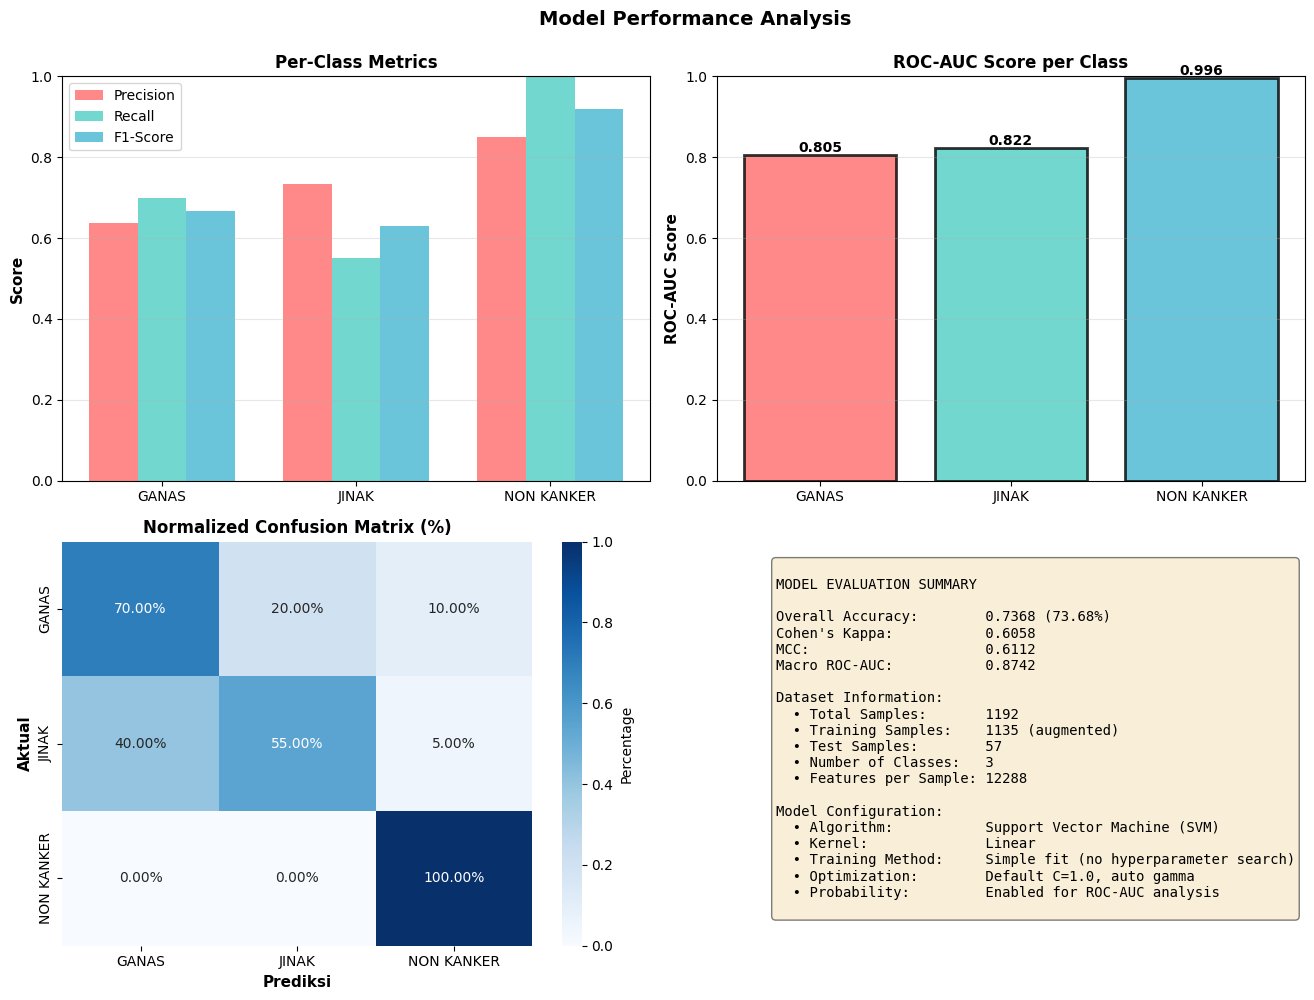


✓ Evaluasi model selesai!


In [32]:
# COMPARISON: MODEL PERFORMANCE SUMMARY
print("\n" + "="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)

# Check if required variables from advanced metrics cell exist
required_vars = ['kappa', 'mcc', 'roc_auc_macro', 'roc_auc', 'precision', 'recall', 'fscore']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print("\n❌ ERROR: Advanced metrics belum dihitung!")
    print("="*70)
    print("⚠️  INSTRUKSI:")
    print("   Jalankan Cell 13 (Advanced Metrics) terlebih dahulu!")
    print(f"   Missing variables: {', '.join(missing_vars)}")
    print("\n   Urutan eksekusi yang benar:")
    print("   1. Cell 10 - Training Model (harus dengan probability=True)")
    print("   2. Cell 11 - Basic Evaluation")
    print("   3. Cell 13 - Advanced Metrics (ROC-AUC, Kappa, MCC)")
    print("   4. Cell 14 - Model Performance Summary (cell ini)")
    print("="*70)
    raise NameError(f"Variables dari advanced metrics belum didefinisikan: {', '.join(missing_vars)}")

# Collect all metrics
metrics_summary = {
    'Metric': [
        'Overall Accuracy',
        'Cohen\'s Kappa',
        'Matthews Correlation Coef.',
        'Macro ROC-AUC',
        'Training Samples',
        'Test Samples',
        'Classes',
        'Features'
    ],
    'Value': [
        f"{accuracy:.4f}",
        f"{kappa:.4f}",
        f"{mcc:.4f}",
        f"{roc_auc_macro:.4f}",
        f"{len(x_train_augmented)}",
        f"{len(x_test)}",
        f"{len(Categories)}",
        f"{x_train_scaled.shape[1]}"
    ]
}

metrics_df = pd.DataFrame(metrics_summary)
print("\n" + metrics_df.to_string(index=False))
print("="*70)

# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Per-class metrics
ax = axes[0, 0]
x_pos = np.arange(len(Categories))
width = 0.25

ax.bar(x_pos - width, precision, width, label='Precision', color='#FF6B6B', alpha=0.8)
ax.bar(x_pos, recall, width, label='Recall', color='#4ECDC4', alpha=0.8)
ax.bar(x_pos + width, fscore, width, label='F1-Score', color='#45B7D1', alpha=0.8)

ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Per-Class Metrics', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(Categories)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# 2. ROC-AUC per class
ax = axes[0, 1]
roc_auc_values = [roc_auc[i] for i in range(len(Categories))]
bars = ax.bar(Categories, roc_auc_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('ROC-AUC Score', fontsize=11, fontweight='bold')
ax.set_title('ROC-AUC Score per Class', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, roc_auc_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Confusion Matrix normalized
ax = axes[1, 0]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=Categories, yticklabels=Categories,
            ax=ax, cbar_kws={'label': 'Percentage'})
ax.set_xlabel('Prediksi', fontsize=11, fontweight='bold')
ax.set_ylabel('Aktual', fontsize=11, fontweight='bold')
ax.set_title('Normalized Confusion Matrix (%)', fontsize=12, fontweight='bold')

# 4. Summary statistics
ax = axes[1, 1]
ax.axis('off')

summary_text = f"""
MODEL EVALUATION SUMMARY

Overall Accuracy:        {accuracy:.4f} ({accuracy*100:.2f}%)
Cohen's Kappa:           {kappa:.4f}
MCC:                     {mcc:.4f}
Macro ROC-AUC:           {roc_auc_macro:.4f}

Dataset Information:
  • Total Samples:       {len(x_train_augmented) + len(x_test)}
  • Training Samples:    {len(x_train_augmented)} (augmented)
  • Test Samples:        {len(x_test)}
  • Number of Classes:   {len(Categories)}
  • Features per Sample: {x_train_scaled.shape[1]}

Model Configuration:
  • Algorithm:           Support Vector Machine (SVM)
  • Kernel:              Linear
  • Training Method:     Simple fit (no hyperparameter search)
  • Optimization:        Default C=1.0, auto gamma
  • Probability:         Enabled for ROC-AUC analysis
"""

ax.text(0.1, 0.95, summary_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Model Performance Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Evaluasi model selesai!")

Sample 1: Pred: JINAK | Confidence: 88.1% | Actual: JINAK
Sample 2: Pred: JINAK | Confidence: 90.7% | Actual: GANAS
Sample 3: Pred: GANAS | Confidence: 97.9% | Actual: JINAK
Sample 4: Pred: NON KANKER | Confidence: 100.0% | Actual: NON KANKER
Sample 5: Pred: JINAK | Confidence: 100.0% | Actual: JINAK
Sample 6: Pred: JINAK | Confidence: 98.5% | Actual: JINAK


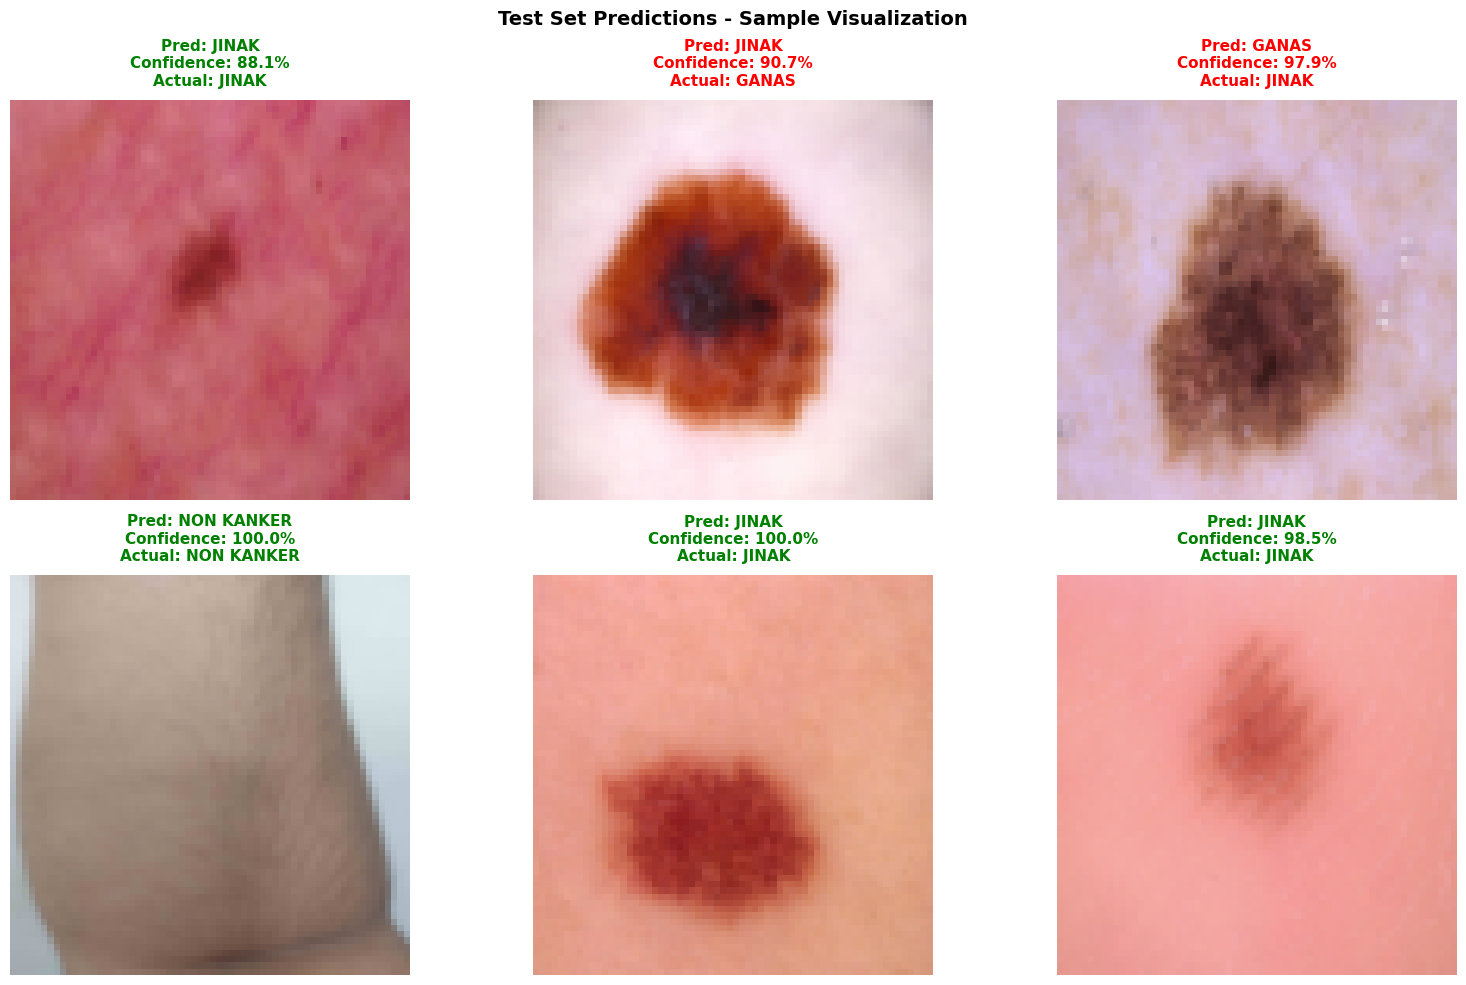


✓ Visualisasi prediksi selesai!
  Garis tebal hijau = Prediksi Benar
  Garis putus merah = Prediksi Salah


In [ ]:
# Ambil maksimal 6 sampel data tes
jumlah_sample = min(6, len(x_test_scaled))

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i in range(jumlah_sample):
    # Reshape data kembali ke bentuk gambar (224x224)
    # Note: gunakan original unscaled data untuk visualisasi
    img_data = x_test.iloc[i].values.reshape(224, 224, 3)
    
    # Ambil probabilitas dari scaled data
    probabilitas = model.predict_proba([x_test_scaled.iloc[i]])[0]
    
    # Label
    prediksi_idx = y_pred[i]
    prediksi_lbl = Categories[prediksi_idx]
    aktual_idx = int(y_test.iloc[i])
    aktual_lbl = Categories[aktual_idx]
    confidence = probabilitas[prediksi_idx] * 100
    
    # Setup Plot
    ax = axes[i]
    ax.imshow(np.clip(img_data, 0, 1))
    ax.axis('off')
    
    # Warna teks judul (Hijau=Benar, Merah=Salah)
    warna = 'green' if prediksi_lbl == aktual_lbl else 'red'
    linestyle = '-' if prediksi_lbl == aktual_lbl else '--'
    linewidth = 3 if prediksi_lbl == aktual_lbl else 2
    
    # Add border
    for spine in ax.spines.values():
        spine.set_edgecolor(warna)
        spine.set_linewidth(linewidth)
        spine.set_linestyle(linestyle)
        spine.set_visible(True)
    
    # Title dengan info prediksi
    title_text = f"Pred: {prediksi_lbl}\nConfidence: {confidence:.1f}%\nActual: {aktual_lbl}"
    ax.set_title(title_text, color=warna, fontsize=11, fontweight='bold', pad=10)
    
    # Add probability bar di bawah
    prob_text = f"Probs: "
    for j, cat in enumerate(Categories):
        prob_text += f"{cat[:3]}:{probabilitas[j]:.2f} "
    print(f"Sample {i+1}: {title_text.replace(chr(10), ' | ')}")

plt.suptitle('Test Set Predictions - Sample Visualization', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n✓ Visualisasi prediksi selesai!")
print("  Garis tebal hijau = Prediksi Benar")
print("  Garis putus merah = Prediksi Salah")



DETAIL HASIL PREDIKSI MODEL

📊 RINGKASAN PREDIKSI:
----------------------------------------------------------------------
Total Test Samples:        57 gambar
Prediksi BENAR (✓):        42 gambar ( 73.68%)
Prediksi SALAH (✗):        15 gambar ( 26.32%)
----------------------------------------------------------------------

📋 BREAKDOWN PER KATEGORI:
----------------------------------------------------------------------

GANAS:
  Total samples:       20
  Prediksi benar:      14 ( 70.00%)
  Prediksi salah:       6
  Salah diklasifikasikan sebagai:
    → JINAK: 4 kali
    → NON KANKER: 2 kali

JINAK:
  Total samples:       20
  Prediksi benar:      11 ( 55.00%)
  Prediksi salah:       9
  Salah diklasifikasikan sebagai:
    → GANAS: 8 kali
    → NON KANKER: 1 kali

NON KANKER:
  Total samples:       17
  Prediksi benar:      17 (100.00%)
  Prediksi salah:       0

----------------------------------------------------------------------


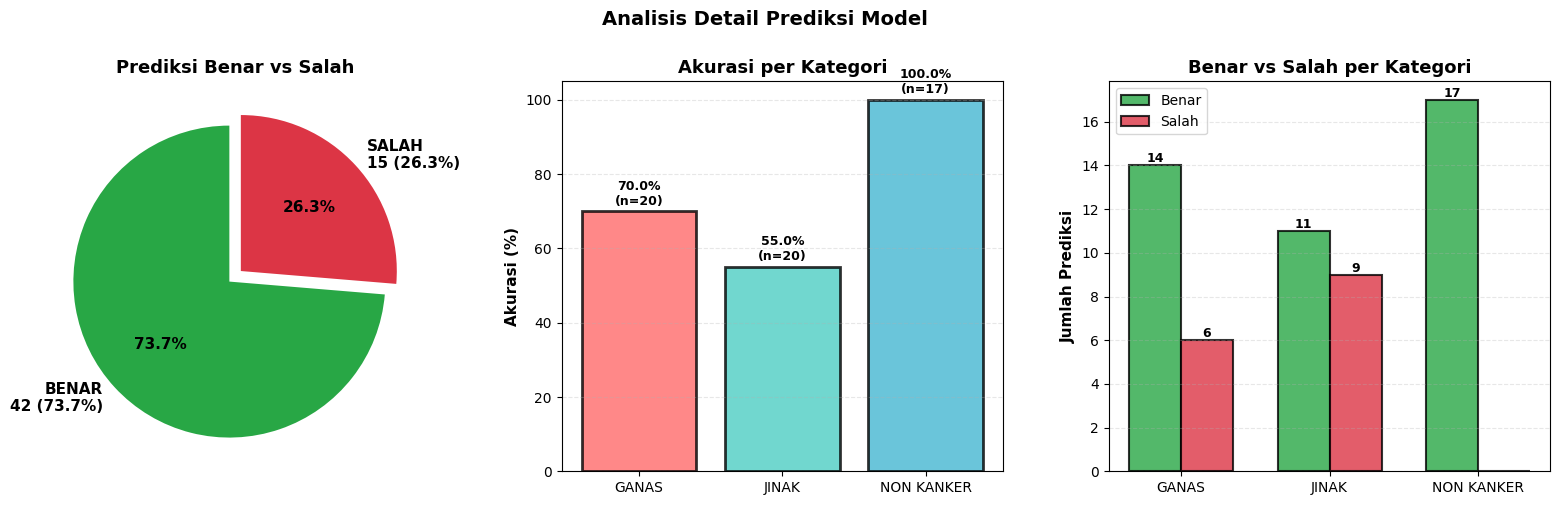


✓ Analisis prediksi selesai!


In [34]:
# ANALISIS PREDIKSI BENAR VS SALAH
print("\n" + "="*70)
print("DETAIL HASIL PREDIKSI MODEL")
print("="*70)

# Hitung prediksi benar dan salah
prediksi_benar = (y_pred == y_test).sum()
prediksi_salah = (y_pred != y_test).sum()
total_prediksi = len(y_test)

# Persentase
persentase_benar = (prediksi_benar / total_prediksi) * 100
persentase_salah = (prediksi_salah / total_prediksi) * 100

print(f"\n📊 RINGKASAN PREDIKSI:")
print("-" * 70)
print(f"Total Test Samples:      {total_prediksi:4} gambar")
print(f"Prediksi BENAR (✓):      {prediksi_benar:4} gambar ({persentase_benar:6.2f}%)")
print(f"Prediksi SALAH (✗):      {prediksi_salah:4} gambar ({persentase_salah:6.2f}%)")
print("-" * 70)

# Breakdown per class
print(f"\n📋 BREAKDOWN PER KATEGORI:")
print("-" * 70)

for i, category in enumerate(Categories):
    # Filter untuk class ini
    mask_class = (y_test == i)
    y_test_class = y_test[mask_class]
    y_pred_class = y_pred[mask_class]
    
    total_class = len(y_test_class)
    benar_class = (y_pred_class == y_test_class).sum()
    salah_class = (y_pred_class != y_test_class).sum()
    akurasi_class = (benar_class / total_class * 100) if total_class > 0 else 0
    
    print(f"\n{category}:")
    print(f"  Total samples:     {total_class:4}")
    print(f"  Prediksi benar:    {benar_class:4} ({akurasi_class:6.2f}%)")
    print(f"  Prediksi salah:    {salah_class:4}")
    
    # Tampilkan kesalahan klasifikasi
    if salah_class > 0:
        print(f"  Salah diklasifikasikan sebagai:")
        for j, other_cat in enumerate(Categories):
            if i != j:
                misclassified = ((y_test == i) & (y_pred == j)).sum()
                if misclassified > 0:
                    print(f"    → {other_cat}: {misclassified} kali")

print("\n" + "-" * 70)

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Pie chart: Benar vs Salah
ax = axes[0]
sizes = [prediksi_benar, prediksi_salah]
labels = [f'BENAR\n{prediksi_benar} ({persentase_benar:.1f}%)', 
          f'SALAH\n{prediksi_salah} ({persentase_salah:.1f}%)']
colors_pie = ['#28a745', '#dc3545']
explode = (0.05, 0.05)

ax.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
       startangle=90, explode=explode, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Prediksi Benar vs Salah', fontsize=13, fontweight='bold')

# 2. Bar chart: Per-class accuracy
ax = axes[1]
class_accuracies = []
class_totals = []

for i in range(len(Categories)):
    mask = (y_test == i)
    total = mask.sum()
    benar = ((y_test == i) & (y_pred == i)).sum()
    akurasi = (benar / total * 100) if total > 0 else 0
    class_accuracies.append(akurasi)
    class_totals.append(total)

bars = ax.bar(Categories, class_accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], 
              alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Akurasi (%)', fontsize=11, fontweight='bold')
ax.set_title('Akurasi per Kategori', fontsize=13, fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Tambahkan label di atas bar
for bar, acc, total in zip(bars, class_accuracies, class_totals):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.1f}%\n(n={total})', ha='center', va='bottom', 
            fontweight='bold', fontsize=9)

# 3. Bar chart: Benar vs Salah per class
ax = axes[2]
x_pos = np.arange(len(Categories))
width = 0.35

benar_per_class = []
salah_per_class = []

for i in range(len(Categories)):
    mask = (y_test == i)
    benar = ((y_test == i) & (y_pred == i)).sum()
    salah = mask.sum() - benar
    benar_per_class.append(benar)
    salah_per_class.append(salah)

bars1 = ax.bar(x_pos - width/2, benar_per_class, width, label='Benar', 
               color='#28a745', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, salah_per_class, width, label='Salah', 
               color='#dc3545', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Jumlah Prediksi', fontsize=11, fontweight='bold')
ax.set_title('Benar vs Salah per Kategori', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(Categories)
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Tambahkan nilai di atas bar
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.suptitle('Analisis Detail Prediksi Model', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✓ Analisis prediksi selesai!")

In [42]:
# SAVE MODEL & DEPENDENCIES
import pickle
import joblib
from datetime import datetime

print("="*70)
print("💾 SAVING MODEL & DEPENDENCIES")
print("="*70)

# Create timestamp untuk versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save model
model_filename = f"cancer_svm_model_{timestamp}.pkl"
joblib.dump(model, model_filename)
print(f"\n✅ Model saved: {model_filename}")
print(f"   Model type: {type(model).__name__}")
print(f"   Kernel: {model.kernel}")
print(f"   Training samples: {len(x_train_augmented):,}")

# 2. Save scaler (PENTING untuk inference!)
scaler_filename = f"cancer_scaler_{timestamp}.pkl"
joblib.dump(scaler, scaler_filename)
print(f"\n✅ Scaler saved: {scaler_filename}")
print(f"   Scaler type: {type(scaler).__name__}")

# 3. Save metadata
metadata = {
    'categories': Categories,
    'image_size': (224, 224, 3),
    'n_features': 224*224*3,
    'accuracy': accuracy,
    'training_samples': len(x_train_augmented),
    'test_samples': len(x_test),
    'timestamp': timestamp,
    'augmentation_factor': AUGMENTATION_FACTOR,
    'model_params': {
        'kernel': model.kernel,
        'C': model.C,
        'gamma': model.gamma,
        'probability': True
    }
}

metadata_filename = f"cancer_model_metadata_{timestamp}.pkl"
with open(metadata_filename, 'wb') as f:
    pickle.dump(metadata, f)
print(f"\n✅ Metadata saved: {metadata_filename}")

# 4. Save model info dalam file text
info_filename = f"cancer_model_info_{timestamp}.txt"
with open(info_filename, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("CANCER CLASSIFICATION MODEL - INFORMATION\n")
    f.write("="*70 + "\n\n")
    f.write(f"Date Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("MODEL CONFIGURATION:\n")
    f.write("-" * 70 + "\n")
    f.write(f"Algorithm:           Support Vector Machine (SVM)\n")
    f.write(f"Kernel:              {model.kernel}\n")
    f.write(f"C:                   {model.C}\n")
    f.write(f"Gamma:               {model.gamma}\n")
    f.write(f"Probability:         {hasattr(model, 'predict_proba')}\n\n")
    
    f.write("DATASET INFORMATION:\n")
    f.write("-" * 70 + "\n")
    f.write(f"Image Resolution:    224×224×3\n")
    f.write(f"Features:            {224*224*3:,}\n")
    f.write(f"Classes:             {', '.join(Categories)}\n")
    f.write(f"Training Samples:    {len(x_train_augmented):,}\n")
    f.write(f"Test Samples:        {len(x_test):,}\n")
    f.write(f"Augmentation:        {AUGMENTATION_FACTOR}x\n\n")
    
    f.write("PERFORMANCE METRICS:\n")
    f.write("-" * 70 + "\n")
    f.write(f"Accuracy:            {accuracy:.4f} ({accuracy*100:.2f}%)\n")
    f.write(f"Cohen's Kappa:       {kappa:.4f}\n")
    f.write(f"MCC:                 {mcc:.4f}\n")
    f.write(f"ROC-AUC (Macro):     {roc_auc_macro:.4f}\n\n")
    
    f.write("PER-CLASS METRICS:\n")
    f.write("-" * 70 + "\n")
    for i, cat in enumerate(Categories):
        f.write(f"{cat}:\n")
        f.write(f"  Precision: {precision[i]:.4f}\n")
        f.write(f"  Recall:    {recall[i]:.4f}\n")
        f.write(f"  F1-Score:  {fscore[i]:.4f}\n")
        f.write(f"  ROC-AUC:   {roc_auc[i]:.4f}\n\n")
    
    f.write("FILES SAVED:\n")
    f.write("-" * 70 + "\n")
    f.write(f"1. Model:     {model_filename}\n")
    f.write(f"2. Scaler:    {scaler_filename}\n")
    f.write(f"3. Metadata:  {metadata_filename}\n")
    f.write(f"4. Info:      {info_filename}\n\n")
    
    f.write("USAGE EXAMPLE:\n")
    f.write("-" * 70 + "\n")
    f.write("import joblib\n")
    f.write("from skimage.io import imread\n")
    f.write("from skimage.transform import resize\n")
    f.write("import numpy as np\n\n")
    f.write("# Load model dan scaler\n")
    f.write(f"model = joblib.load('{model_filename}')\n")
    f.write(f"scaler = joblib.load('{scaler_filename}')\n\n")
    f.write("# Load dan preprocess image\n")
    f.write("img = imread('path/to/image.jpg')\n")
    f.write("img_resized = resize(img, (224, 224, 3))\n")
    f.write("img_normalized = img_resized / 255.0 if img_resized.max() > 1 else img_resized\n")
    f.write("img_flat = img_normalized.flatten().reshape(1, -1)\n\n")
    f.write("# Scale dan predict\n")
    f.write("img_scaled = scaler.transform(img_flat)\n")
    f.write("prediction = model.predict(img_scaled)[0]\n")
    f.write("probabilities = model.predict_proba(img_scaled)[0]\n\n")
    f.write(f"categories = {Categories}\n")
    f.write("print(f'Prediction: {categories[prediction]}')\n")
    f.write("print(f'Confidence: {probabilities[prediction]*100:.2f}%')\n")

print(f"\n✅ Model info saved: {info_filename}")

print("\n" + "="*70)
print("📦 SUMMARY - FILES SAVED:")
print("="*70)
print(f"1. 🤖 Model:        {model_filename}")
print(f"2. 📏 Scaler:       {scaler_filename}")
print(f"3. 📋 Metadata:     {metadata_filename}")
print(f"4. 📄 Info:         {info_filename}")
print("="*70)

print("\n✅ All files saved successfully!")
print("\n💡 CARA MENGGUNAKAN MODEL:")
print("-" * 70)
print("1. Load model dan scaler:")
print(f"   model = joblib.load('{model_filename}')")
print(f"   scaler = joblib.load('{scaler_filename}')")
print("\n2. Preprocess image baru (224×224×3, normalized [0,1])")
print("3. Flatten dan scale dengan scaler")
print("4. Predict dengan model.predict()")
print("\n📖 Lihat file info untuk contoh lengkap!")

💾 SAVING MODEL & DEPENDENCIES

✅ Model saved: cancer_svm_model_20260110_235537.pkl
   Model type: SVC
   Kernel: linear
   Training samples: 1,589

✅ Scaler saved: cancer_scaler_20260110_235537.pkl
   Scaler type: StandardScaler

✅ Metadata saved: cancer_model_metadata_20260110_235537.pkl

✅ Model info saved: cancer_model_info_20260110_235537.txt

📦 SUMMARY - FILES SAVED:
1. 🤖 Model:        cancer_svm_model_20260110_235537.pkl
2. 📏 Scaler:       cancer_scaler_20260110_235537.pkl
3. 📋 Metadata:     cancer_model_metadata_20260110_235537.pkl
4. 📄 Info:         cancer_model_info_20260110_235537.txt

✅ All files saved successfully!

💡 CARA MENGGUNAKAN MODEL:
----------------------------------------------------------------------
1. Load model dan scaler:
   model = joblib.load('cancer_svm_model_20260110_235537.pkl')
   scaler = joblib.load('cancer_scaler_20260110_235537.pkl')

2. Preprocess image baru (224×224×3, normalized [0,1])
3. Flatten dan scale dengan scaler
4. Predict dengan model.pr

In [ ]:
# CONTOH PENGGUNAAN MODEL YANG SUDAH DISAVE
# Copy cell ini jika mau test load model di notebook baru

"""
import joblib
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# 1. LOAD MODEL & DEPENDENCIES
print("Loading model dan dependencies...")
model = joblib.load('cancer_svm_model_YYYYMMDD_HHMMSS.pkl')  # Ganti dengan filename yang sesuai
scaler = joblib.load('cancer_scaler_YYYYMMDD_HHMMSS.pkl')    # Ganti dengan filename yang sesuai

categories = ['GANAS', 'JINAK', 'NON KANKER']
print("✅ Model loaded successfully!")

# 2. FUNCTION UNTUK PREDICT IMAGE BARU
def predict_cancer_image(image_path, show_image=True):
    # Load image
    img = imread(image_path)
    
    # Handle grayscale
    if len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    
    # Resize ke 224x224x3
    img_resized = resize(img, (224, 224, 3))
    
    # Normalize [0, 1]
    img_normalized = img_resized.astype(np.float32)
    if img_normalized.max() > 1:
        img_normalized = img_normalized / 255.0
    
    # Flatten dan reshape
    img_flat = img_normalized.flatten().reshape(1, -1)
    
    # Scale
    img_scaled = scaler.transform(img_flat)
    
    # Predict
    prediction = model.predict(img_scaled)[0]
    probabilities = model.predict_proba(img_scaled)[0]
    
    result = {
        'class': categories[prediction],
        'class_index': int(prediction),
        'confidence': float(probabilities[prediction] * 100),
        'probabilities': {cat: float(prob*100) for cat, prob in zip(categories, probabilities)}
    }
    
    # Visualisasi
    if show_image:
        plt.figure(figsize=(10, 6))
        
        # Image
        plt.subplot(1, 2, 1)
        plt.imshow(np.clip(img_resized, 0, 1))
        plt.axis('off')
        plt.title(f"Predicted: {result['class']}\\nConfidence: {result['confidence']:.2f}%", 
                  fontsize=12, fontweight='bold')
        
        # Probabilities
        plt.subplot(1, 2, 2)
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        bars = plt.bar(categories, probabilities*100, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        plt.ylabel('Probability (%)', fontsize=11, fontweight='bold')
        plt.title('Class Probabilities', fontsize=12, fontweight='bold')
        plt.ylim([0, 105])
        plt.grid(axis='y', alpha=0.3)
        
        # Add values on bars
        for bar, prob in zip(bars, probabilities*100):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{prob:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    return result

# 3. TEST PREDICT
# Uncomment dan ganti dengan path image yang mau di-test
# result = predict_cancer_image('path/to/test/image.jpg')
# print("\\nPrediction Result:")
# print(f"Class: {result['class']}")
# print(f"Confidence: {result['confidence']:.2f}%")
# print("\\nAll Probabilities:")
# for cat, prob in result['probabilities'].items():
#     print(f"  {cat}: {prob:.2f}%")

# 4. BATCH PREDICTION
# Uncomment untuk predict multiple images
# import os
# test_folder = 'path/to/test/folder'
# results = []
# 
# for img_file in os.listdir(test_folder):
#     if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
#         img_path = os.path.join(test_folder, img_file)
#         result = predict_cancer_image(img_path, show_image=False)
#         results.append({
#             'file': img_file,
#             'prediction': result['class'],
#             'confidence': result['confidence']
#         })
# 
# # Print results
# import pandas as pd
# df_results = pd.DataFrame(results)
# print(df_results)
# 
# # Save results
# df_results.to_csv('prediction_results.csv', index=False)
# print("✅ Results saved to prediction_results.csv")
"""

print("="*70)
print("📖 CONTOH PENGGUNAAN MODEL")
print("="*70)
print("\n💡 Cell ini berisi template code untuk:")
print("   1. Load model yang sudah disave")
print("   2. Function untuk predict image baru")
print("   3. Visualisasi hasil prediksi")
print("   4. Batch prediction untuk multiple images")
print("\n⚠️  Code ada dalam triple quotes (''')")
print("   Uncomment dan copy ke notebook baru untuk digunakan")
print("="*70)

In [ ]:
# PERBAIKAN MODEL - QUICK WINS IMPLEMENTATION
print("="*70)
print("IMPLEMENTASI PERBAIKAN MODEL - QUICK WINS")
print("="*70)

print("\n🔧 STRATEGI PERBAIKAN:")
print("1. Tingkatkan augmentasi factor dari 2 ke 4")
print("2. Tambah class weights untuk handle confusion GANAS-JINAK")
print("3. Coba kernel RBF yang lebih fleksibel")
print("4. Tingkatkan max_iter untuk convergence lebih baik")
print("\n💡 Untuk implementasi, jalankan cell-cell berikut:")
print("   1. Ubah AUGMENTATION_FACTOR di Cell 9 dari 2 ke 4")
print("   2. Re-run Cell 9 (Augmentation)")
print("   3. Jalankan cell di bawah ini untuk training dengan perbaikan")
print("="*70)

# Cell untuk re-training dengan perbaikan
# Uncomment dan jalankan setelah augmentation dengan factor=4

"""
from sklearn.utils.class_weight import compute_class_weight
import time
import sys

print("\n" + "="*70)
print("TRAINING IMPROVED MODEL")
print("="*70)

# Check augmentation
if len(x_train_augmented) < 800:
    print("\n⚠️  WARNING: Augmentation factor masih rendah!")
    print(f"   Current training samples: {len(x_train_augmented)}")
    print(f"   Expected with factor=4: ~900 samples")
    print("\n   Silakan update AUGMENTATION_FACTOR=4 di Cell 9 dan re-run!")
    raise ValueError("Jalankan Cell 9 dengan AUGMENTATION_FACTOR=4 terlebih dahulu!")

# Compute class weights untuk handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_augmented),
    y=y_train_augmented
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"\n⚖️  CLASS WEIGHTS (untuk handle confusion GANAS-JINAK):")
for i, cat in enumerate(Categories):
    print(f"   {cat:12}: {class_weight_dict[i]:.4f}")

start_time = time.time()

n_samples = len(x_train_augmented)
n_features = x_train_augmented.shape[1]

print(f"\n📊 Dataset Information:")
print(f"   Training samples: {n_samples:,}")
print(f"   Features: {n_features:,}")

# IMPROVED MODEL CONFIG
print(f"\n⏳ Training IMPROVED SVM...")
print(f"   Changes:")
print(f"   • Kernel: RBF (more flexible than linear)")
print(f"   • Class weights: Balanced")
print(f"   • Max iterations: 50,000")
print(f"   • Cache size: 2000 MB")
print()

model_improved = svm.SVC(
    kernel='rbf',              # RBF kernel untuk non-linear patterns
    class_weight='balanced',   # Automatic class balancing
    probability=True,
    verbose=True,
    max_iter=50000,           # Increased iterations
    cache_size=2000,          # Larger cache
    random_state=77
)

print("="*70)
print("🚀 TRAINING STARTED...")
print("="*70)

try:
    model_improved.fit(x_train_augmented, y_train_augmented)
    training_success = True
except Exception as e:
    print(f"\n❌ Error: {str(e)}")
    training_success = False
    raise
finally:
    end_time = time.time()
    durasi = (end_time - start_time) / 60

if training_success:
    print("\n" + "="*70)
    print("✅ IMPROVED MODEL TRAINING COMPLETE!")
    print("="*70)
    print(f"⏱️  Training time: {durasi:.2f} minutes")
    print(f"🎯 Model: SVM-RBF with balanced class weights")
    print("="*70)
    
    # Quick evaluation
    y_pred_improved = model_improved.predict(x_test_scaled)
    accuracy_improved = accuracy_score(y_test, y_pred_improved)
    
    print(f"\n📊 QUICK COMPARISON:")
    print(f"   Original model (linear): {accuracy*100:.2f}%")
    print(f"   Improved model (RBF):    {accuracy_improved*100:.2f}%")
    print(f"   Improvement:              {(accuracy_improved-accuracy)*100:+.2f}%")
    
    # Check confusion matrix
    cm_improved = confusion_matrix(y_test, y_pred_improved)
    print(f"\n🔍 CONFUSION ANALYSIS:")
    print(f"   Original - JINAK→GANAS errors: {cm[1,0]}")
    print(f"   Improved - JINAK→GANAS errors: {cm_improved[1,0]}")
    print(f"   Original - GANAS→JINAK errors: {cm[0,1]}")
    print(f"   Improved - GANAS→JINAK errors: {cm_improved[0,1]}")
    
    if accuracy_improved > accuracy:
        print(f"\n✅ IMPROVEMENT SUCCESSFUL!")
        print(f"   Gunakan 'model_improved' untuk evaluasi lanjutan")
        model = model_improved  # Replace global model
        y_pred = y_pred_improved
        accuracy = accuracy_improved
        cm = cm_improved
    else:
        print(f"\n⚠️  No significant improvement")
        print(f"   Might need more augmentation or different approach")
"""

print("\n💡 CARA PENGGUNAAN:")
print("1. Edit Cell 9: Ubah AUGMENTATION_FACTOR = 4")
print("2. Re-run Cell 9 untuk augmentasi lebih banyak data")
print("3. Uncomment code di cell ini (hapus ''' di atas/bawah)")
print("4. Jalankan cell ini untuk training model yang diperbaiki")
print("5. Model baru akan otomatis replace model lama jika lebih baik")